In [58]:
import sys
sys.path.append("../")

In [59]:
import ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pogw.pogw_2 import partial_order_gromov_wasserstein
from src.gdtw.GDTW import gromov_dtw
from src.experiments.digit_moving.utils import add_outlier, random_swap, get_ground_truth,get_ground_truth_matrix, soft_assigment_to_matching

In [60]:
digit = np.random.randint(0,10)

mnist_data = np.load(f"../Datasets/mnist_moving/{digit}.npy").astype(np.float64)
usps_data = np.load(f"../Datasets/usps_moving/{digit}.npy").astype(np.float64)
mnist_order = [i for i in range(mnist_data.shape[0])]
usps_order = [i for i in range(usps_data.shape[0])]
print(mnist_data.shape, usps_data.shape)
print(mnist_data.max(), mnist_data.min())
print(usps_data.max(), usps_data.min())


mnist_data, mnist_order = random_swap(mnist_data, mnist_order)
mnist_data, mnist_order = add_outlier(mnist_data, mnist_order, n_outliers=2, norm=False)
usps_data, usps_order = add_outlier(usps_data, usps_order, n_outliers=2, norm=False)


flatten_usps_data = np.array([i.flatten() for i in usps_data])
flatten_mnist_data = np.array([i.flatten() for i in mnist_data])

(20, 47, 47) (20, 35, 35)
255.0 0.0
226.0 0.0


In [61]:
print(mnist_order)
print(usps_order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1, 14, 16, 15, 17, -1, 18, 19]
[0, 1, 2, 3, 4, 5, -1, 6, 7, 8, -1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


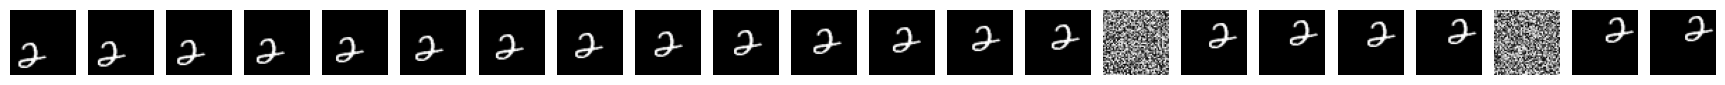

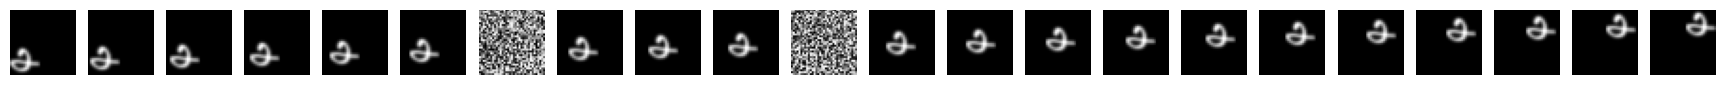

In [62]:
len_seq = mnist_data.shape[0]
plt.figure(figsize=(len_seq,len_seq))
for i in range(len_seq):
    plt.subplot(1,len_seq,i+1)
    plt.imshow(mnist_data[i], cmap="gray")
    plt.axis("off")

plt.figure(figsize=(len_seq,len_seq))
for i in range(len_seq):
    plt.subplot(1,len_seq,i+1)
    plt.imshow(usps_data[i], cmap="gray")
    plt.axis("off")

<Axes: >

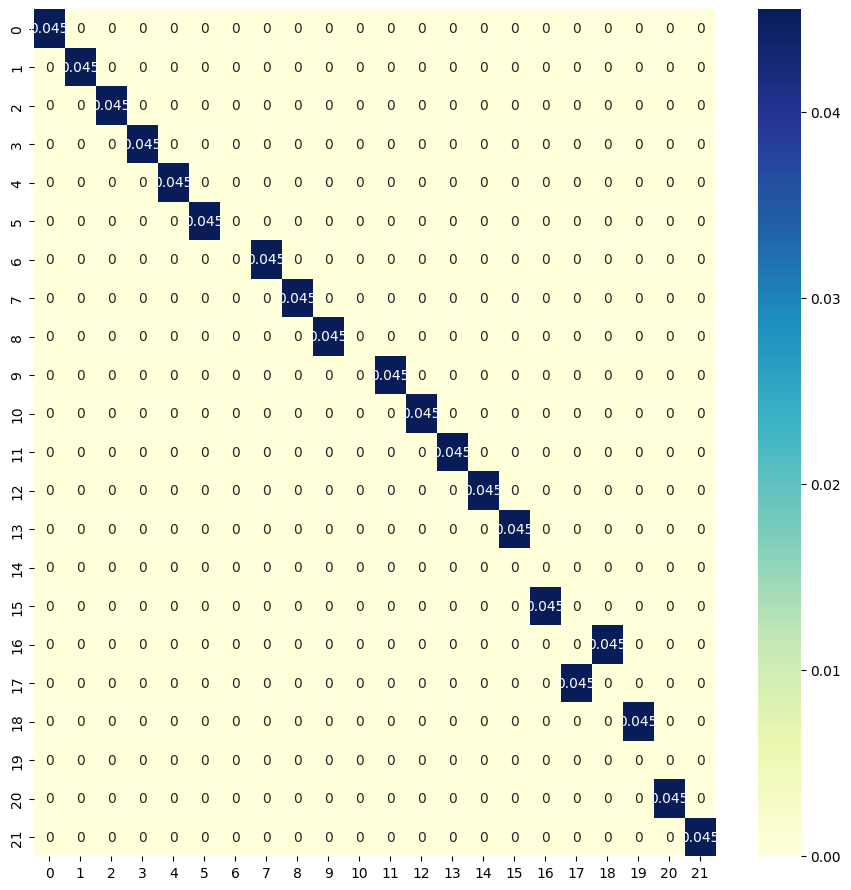

In [63]:
C1 = ot.dist(flatten_mnist_data,metric="euclidean").astype(np.float64)
C2 = ot.dist(flatten_usps_data,metric="euclidean").astype(np.float64)

C1 = C1 / C1.mean()
C2 = C2 / C2.mean()

p1 = ot.unif(C1.shape[0])
p2 = ot.unif(C2.shape[0])

T = partial_order_gromov_wasserstein(C1,C2,p1,p2,m = 20/22, order_reg=0.01, return_dist=False)
plt.figure(figsize=(len_seq//2,len_seq//2))
sns.heatmap(T.round(4),cmap="YlGnBu",annot = True)

In [64]:
ground_truth_matrix = get_ground_truth_matrix(mnist_order, usps_order)
ground_truth_matching = get_ground_truth(mnist_order, usps_order)
predicted_matching = soft_assigment_to_matching(T)

<Axes: >

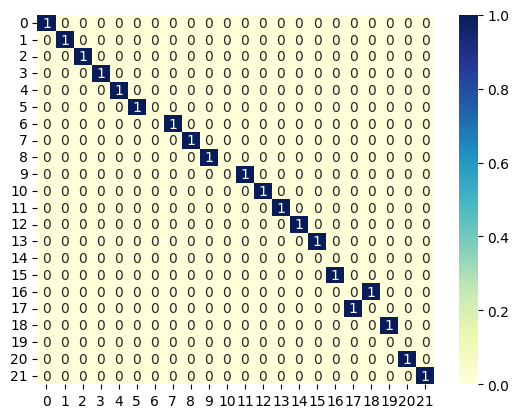

In [65]:
sns.heatmap(ground_truth_matrix.round(4),cmap="YlGnBu",annot = True)

In [66]:
predicted_matching

[(-1, 6),
 (-1, 10),
 (0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 11),
 (10, 12),
 (11, 13),
 (12, 14),
 (13, 15),
 (14, -1),
 (15, 16),
 (16, 18),
 (17, 17),
 (18, 19),
 (19, -1),
 (20, 20),
 (21, 21)]

In [67]:
ground_truth_matching

[(-1, 6),
 (-1, 10),
 (0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 11),
 (10, 12),
 (11, 13),
 (12, 14),
 (13, 15),
 (14, -1),
 (15, 16),
 (16, 18),
 (17, 17),
 (18, 19),
 (19, -1),
 (20, 20),
 (21, 21)]

In [68]:
len(ground_truth_matching)

24

In [69]:
len(predicted_matching)

24

In [70]:
# Accuracy
correct = 0
for i in predicted_matching:
    if i in ground_truth_matching:
        correct += 1
print(f"Accuracy: {correct/len(predicted_matching)}")


# iou
iou = 0
for i in predicted_matching:
    if i in ground_truth_matching:
        iou += 1
iou = iou / (len(predicted_matching) + len(ground_truth_matching) - iou)
print(f"IOU: {iou}")

Accuracy: 1.0
IOU: 1.0


### For GDTW

In [71]:
import torch
def gromov_dtw_alignment(x1, x2):
    GDTW = gromov_dtw(
            max_iter=50, gamma=0.1, loss_only=0, dtw_approach="GDTW", verbose=0
        )
    x1 = torch.from_numpy(x1)
    x2 = torch.from_numpy(x2)
    result = GDTW.forward(x1, x2)
    return result[1]

In [72]:
alignment = gromov_dtw_alignment(flatten_mnist_data, flatten_usps_data)

In [73]:
T = alignment.numpy()

<Axes: >

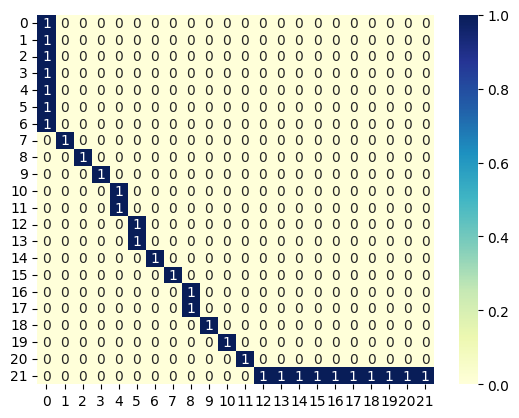

In [74]:
sns.heatmap(T.round(4),cmap="YlGnBu",annot = True)

In [75]:
ground_truth_matrix = get_ground_truth_matrix(mnist_order, usps_order)
ground_truth_matching = get_ground_truth(mnist_order, usps_order)
predicted_matching = soft_assigment_to_matching(T)

In [76]:
# Accuracy
correct = 0
for i in predicted_matching:
    if i in ground_truth_matching:
        correct += 1
print(f"Accuracy: {correct/len(predicted_matching)}")


# iou
iou = 0
for i in predicted_matching:
    if i in ground_truth_matching:
        iou += 1
iou = iou / (len(predicted_matching) + len(ground_truth_matching) - iou)
print(f"IOU: {iou}")

Accuracy: 0.06451612903225806
IOU: 0.03773584905660377
